In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sys.path.append('/n/coxfs01/cechavarria/repos/2p-pipeline/')

In [223]:
class struct: pass

opts = struct()
opts.rootdir = '/n/coxfs01/2p-data'
opts.animalid = 'JC105'
opts.session = '20190826'
opts.acquisition = 'FOV1_zoom4p0x'
opts.traceid = 'traces101'

opts.combined_run = 'scenes_combined'



traceid = '%s_s2p'%(opts.traceid)
#% Set up paths:    
acquisition_dir = os.path.join(opts.rootdir, opts.animalid, opts.session, opts.acquisition)

traceid_dir = os.path.join(acquisition_dir, opts.combined_run,'traces', traceid)

run_dir = traceid_dir.split('/traces')[0]
trace_arrays_dir = os.path.join(traceid_dir,'files')
paradigm_dir = os.path.join(acquisition_dir, opts.combined_run, 'paradigm')

#output directory
responses_dir = os.path.join(acquisition_dir, opts.combined_run,'responses', traceid)

   
if not os.path.exists(os.path.join(responses_dir,'figures')):
    os.makedirs(os.path.join(responses_dir,'figures'))

In [3]:
#open file to read
data_array_fn = 'processed_config_traces.hdf5'
data_array_filepath = os.path.join(traceid_dir, 'data_arrays', data_array_fn)
print(data_array_filepath)
data_grp = h5py.File(data_array_filepath, 'r')

frames_tsec = data_grp.attrs['frames_tsec']
nrois = data_grp.attrs['nrois']
print('ROIs:%i'%(nrois))


if 's2p_cell_rois' in data_grp.attrs.keys():
    cell_rois = data_grp.attrs['s2p_cell_rois']
else:
    cell_rois = np.arange(nrois)

curr_slice = 'Slice01'#hard,coding for now
stim_period0 = data_grp.attrs['pre_frames']
stim_period1 = data_grp.attrs['pre_frames']+data_grp.attrs['stim_frames']+1

trial_fid = np.array(data_grp.attrs['trial_fid'])
trial_run = np.array(data_grp.attrs['trial_run'])

/n/coxfs01/2p-data/JC105/20190826/FOV1_zoom4p0x/scenes_combined/traces/traces101_s2p/data_arrays/processed_config_traces.hdf5
ROIs:181


In [4]:
config_img = np.zeros((len(data_grp[curr_slice].keys())))
config_cond = np.zeros((len(data_grp[curr_slice].keys())))
for cfg_count,cfg_key in enumerate(data_grp[curr_slice].keys()):
    config_img[cfg_count] = np.array(data_grp['/'.join([curr_slice,cfg_key,'img'])])[0]+1
    config_cond[cfg_count] = np.array(data_grp['/'.join([curr_slice,cfg_key,'scene_cond'])])[0]

# cfg_key = 'config006'
# cfg_count = 0 
# print(np.array(data_grp[curr_slice][cfg_key]['img']))
# print(np.array(data_grp[curr_slice][cfg_key]['scene_cond']))

for cfg_count,cfg_key in enumerate(data_grp[curr_slice].keys()):
  #  print(cfg_key)
    trial_traces_f = np.array(data_grp['/'.join([curr_slice,cfg_key,'f', 'trace','np_subtracted'])])
    trial_traces_df = np.array(data_grp['/'.join([curr_slice,cfg_key,'df', 'trace','np_subtracted'])])
    trial_traces_df_f = np.array(data_grp['/'.join([curr_slice,cfg_key,'df_f', 'trace','np_subtracted'])])
    trial_traces_zscore = np.array(data_grp['/'.join([curr_slice,cfg_key,'zscore', 'trace','np_subtracted'])])

    trial_response_df = np.squeeze(np.mean(trial_traces_df[:,stim_period0:stim_period1,:],1))
    trial_response_df_f = np.squeeze(np.mean(trial_traces_df_f[:,stim_period0:stim_period1,:],1))
    trial_response_zscore = np.squeeze(np.mean(trial_traces_zscore[:,stim_period0:stim_period1,:],1))

    trial_baseline_f = np.squeeze(np.mean(trial_traces_f[:,0:stim_period0,:],1))
    trial_response_f = np.squeeze(np.mean(trial_traces_f[:,stim_period0:stim_period1,:],1))
    trial_response_f_zscore = np.true_divide(trial_response_f-np.mean(trial_baseline_f,0),\
               np.std(trial_baseline_f,0))

    if cfg_count == 0:
        response_matrix_df = trial_response_df
        response_matrix_df_f = trial_response_df_f
        response_matrix_zscore = trial_response_zscore
        response_matrix_f_zscore = trial_response_f_zscore
        response_matrix_f = trial_response_f
        baseline_matrix_f = trial_baseline_f
    else:
        response_matrix_df = np.dstack((response_matrix_df,trial_response_df))
        response_matrix_df_f = np.dstack((response_matrix_df_f,trial_response_df_f))
        response_matrix_zscore = np.dstack((response_matrix_zscore,trial_response_zscore))
        response_matrix_f_zscore = np.dstack((response_matrix_f_zscore,trial_response_f_zscore))
        response_matrix_f = np.dstack((response_matrix_f,trial_response_f))
        baseline_matrix_f = np.dstack((baseline_matrix_f,trial_baseline_f))

response_matrix_f = np.swapaxes(response_matrix_f,1,2) 
baseline_matrix_f = np.swapaxes(baseline_matrix_f,1,2) 
response_matrix_df = np.swapaxes(response_matrix_df,1,2) 
response_matrix_df_f = np.swapaxes(response_matrix_df_f,1,2) 
response_matrix_zscore = np.swapaxes(response_matrix_zscore,1,2) 
response_matrix_f_zscore = np.swapaxes(response_matrix_f_zscore,1,2)

In [247]:
ridx = 10
cidx = 14
cfg_key = 'config%03d'%(cidx)

roi_all_trial_trace = np.array(data_grp['/'.join([curr_slice,cfg_key,'df', 'trace','np_subtracted'])])[:,:,ridx]
roi_mean_trial_trace = np.mean(np.array(data_grp['/'.join([curr_slice,cfg_key,'df', 'trace','np_subtracted'])])[:,:,ridx],0)
roi_med_trial_trace = np.median(np.array(data_grp['/'.join([curr_slice,cfg_key,'df', 'trace','np_subtracted'])])[:,:,ridx],0)

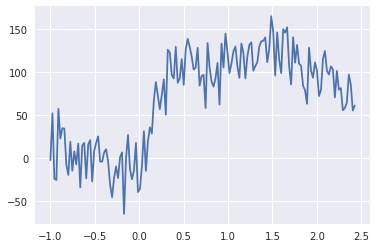

In [248]:
#showing mean reponse profile
plt.plot(frames_tsec,roi_mean_trial_trace);

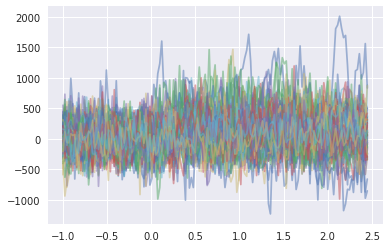

In [249]:
#showing all traces
for tidx in range(roi_all_trial_trace.shape[0]):
    plt.plot(frames_tsec,roi_all_trial_trace[tidx,:],alpha =0.5)

tstat = 7.6274 | pval = 6.50E-12


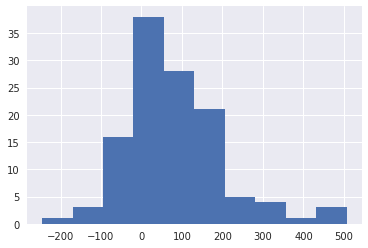

In [250]:
#histogram of all trials
roi_cfg_responses = response_matrix_df[:,cidx,ridx]
plt.hist(roi_cfg_responses);
[tstat,pval] = stats.ttest_1samp(roi_cfg_responses,0)
print('tstat = %.04f | pval = %.2E'%(tstat,pval))

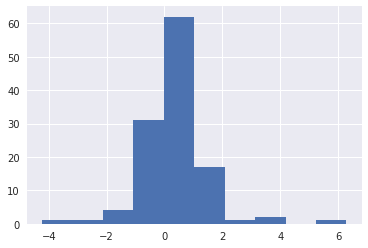

In [216]:
cell_responses = response_matrix_df[:,:,ridx]

cell_responses_zscore = scipy.stats.zscore(cell_responses.flatten())
cell_responses_zscore = np.reshape(cell_responses_zscore,cell_responses.shape)

#histogram of all trials
roi_cfg_responses = cell_responses_zscore[:,cidx]
plt.hist(roi_cfg_responses);


In [72]:
response_matrix_df_cells = response_matrix_df[:,:,cell_rois]


ntrials, nconfigs, nrois = response_matrix_df_cells.shape

simple_tstat = np.empty((nconfigs,nrois))
simple_p = np.empty((nconfigs,nrois))


#get t-stats
for cidx in range(nconfigs):
        for ridx in range(nrois):
            simple_tstat[cidx,ridx], simple_p[cidx,ridx] = stats.ttest_1samp(np.squeeze(response_matrix_df_cells[:,cidx,ridx]),0)

#sign your p-values
simple_p = np.sign(simple_tstat)*simple_p

In [147]:
simple_tstat[0,3]

9.7960560377360348

In [159]:
# p_thresh = .05
# thresh_matrix = simple_p < p_thresh
tstat_thresh = 3
thresh_matrix = simple_tstat > tstat_thresh

In [151]:
activ_units = np.sum(thresh_matrix,0)>1

num_activ_units = np.sum(activ_units)
frac_activ_units = num_activ_units/float(nrois)

print('Total Active Units = %i'%(num_activ_units))

print('Fraction Active Units = %.03f'%(frac_activ_units))

Total Active Units = 82
Fraction Active Units = 0.562


In [76]:
#randomly sub-sampling responses

146

In [176]:
nreps = 100
subset_size_list = np.arange(5,int(np.floor(ntrials))+5,5)#np.array([4,8,12])
thresh_list = np.array([2,3,4])
active_count= np.zeros((subset_size_list.size,thresh_list.size,nreps))


for rep in range(nreps):
    print(rep)
    for subset_idx,subset_size in enumerate(subset_size_list):
        # rep = 0
        # subset_idx = 0
        # subset_size = 60

        #randomly subsample
        rand_trials = np.random.permutation(ntrials)
        subset_response = response_matrix_df_cells[rand_trials[0:subset_size],:,:]

        #get t-stat
        sub_tstat = np.empty((nconfigs,nrois))
        sub_p = np.empty((nconfigs,nrois))
        for cidx in range(nconfigs):
                for ridx in range(nrois):
                    sub_tstat[cidx,ridx], sub_p[cidx,ridx] = stats.ttest_1samp(np.squeeze(subset_response[:,cidx,ridx]),0)

        for thresh_idx,thresh in enumerate(thresh_list):
            thresh_matrix = sub_tstat > thresh
            activ_units = np.sum(thresh_matrix,0)>1

            active_count[subset_idx,thresh_idx,rep] = np.sum(activ_units)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [219]:
thresh_idx

2

In [220]:
active_frac = active_count/float(nrois)
active_frac_mean = np.mean(active_frac,2)
active_frac_se = np.std(active_frac,2)/np.sqrt(nreps)

In [221]:
active_frac_diff = np.diff(active_frac,axis=0)/5.0

active_frac_diff_mean = np.nanmean(active_frac_diff,2)
active_frac_diff_se = np.nanstd(active_frac_diff,2)/np.sqrt(nreps)

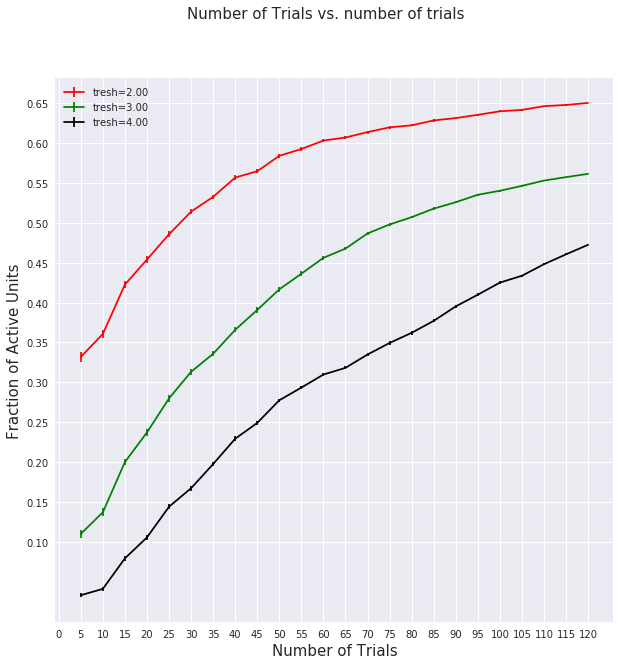

In [230]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(subset_size_list,active_frac_mean[:,0],yerr = active_frac_se[:,0],color = 'r',label='tresh=%.02f'%(thresh_list[0]))
plt.errorbar(subset_size_list,active_frac_mean[:,1],yerr = active_frac_se[:,1],color = 'g',label='tresh=%.02f'%(thresh_list[1]))
plt.errorbar(subset_size_list,active_frac_mean[:,2],yerr = active_frac_se[:,2],color = 'k',label='tresh=%.02f'%(thresh_list[2]))
plt.legend()
plt.ylabel('Fraction of Active Units',fontsize = 15)
plt.xlabel('Number of Trials',fontsize = 15)
plt.suptitle('Number of Trials vs. number of trials', fontsize = 15)

plt.legend()
axes = plt.gca()
axes.set_yticks(np.arange(.1,.70,.05))
axes.set_xticks(np.arange(0,125,5))
fig_fn = '%s_%s_num_active_units_vs_ntrials_%s.png'%(opts.animalid, opts.session,'simple_tstat')
plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [143]:
active_frac_mean

array([ 0.33061644,  0.36773973,  0.41465753,  0.45589041,  0.48678082,
        0.51780822,  0.53938356,  0.55527397,  0.56808219,  0.58732877,
        0.59116438,  0.5990411 ,  0.61027397,  0.61513699,  0.62034247,
        0.62410959,  0.62890411,  0.62931507,  0.63657534,  0.63965753,
        0.64246575,  0.64534247,  0.64773973,  0.65068493])

Text(0.5,0.98,u'Number of Trials vs. number of trials')

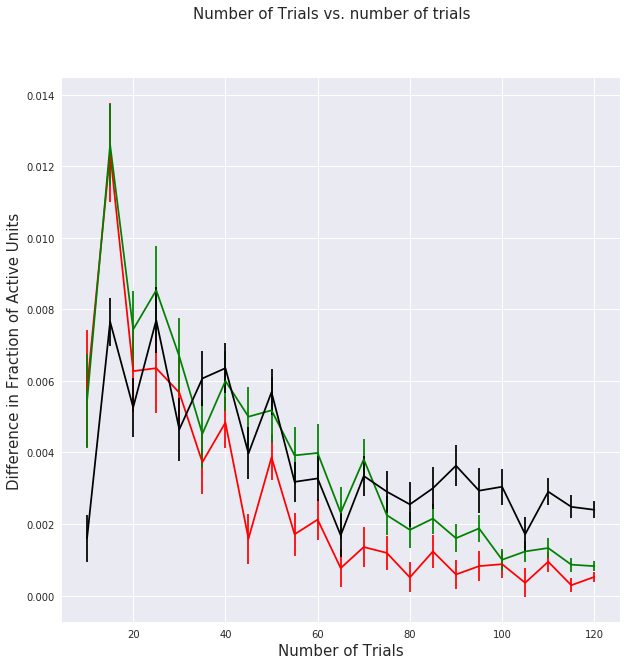

In [233]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(subset_size_list[1:],active_frac_diff_mean[:,0],yerr = active_frac_diff_se[:,0],color = 'r',label='tresh=%.02f'%(thresh_list[0]))
plt.errorbar(subset_size_list[1:],active_frac_diff_mean[:,1],yerr = active_frac_diff_se[:,1],color = 'g',label='tresh=%.02f'%(thresh_list[1]))
plt.errorbar(subset_size_list[1:],active_frac_diff_mean[:,2],yerr = active_frac_diff_se[:,2],color = 'k',label='tresh=%.02f'%(thresh_list[2]))
plt.ylabel('Difference in Fraction of Active Units',fontsize = 15)
plt.xlabel('Number of Trials',fontsize = 15)
plt.suptitle('Number of Trials vs. number of trials', fontsize = 15)

In [251]:
#let's check mean and variance of t-tests
simple_tstat.shape

(15, 146)

In [252]:
mean_df = np.mean(response_matrix_df_cells,0)
var_df = np.var(response_matrix_df_cells,0)

/home/cesar/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


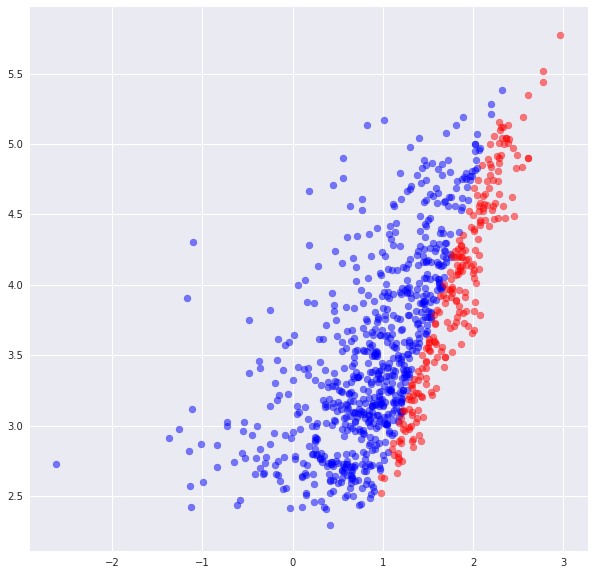

In [519]:
fig = plt.figure(figsize=(10,10))
tstat_thresh = 5
#plt.scatter(mean_df.flatten()[simple_tstat],var_df.flatten(),alpha = 0.5)
plt.scatter(np.log10(mean_df.flatten()[simple_tstat.flatten()<=tstat_thresh]),\
            np.log10(var_df.flatten()[simple_tstat.flatten()<=tstat_thresh]),color = 'b', alpha = 0.5)
plt.scatter(np.log10(mean_df.flatten()[simple_tstat.flatten()>tstat_thresh]),\
            np.log10(var_df.flatten()[simple_tstat.flatten()>tstat_thresh]),color = 'r', alpha = 0.5)

In [270]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [272]:
matrix_df_cells.shape

NameError: name 'matrix_df_cells' is not defined

In [292]:
import inspect

In [313]:
nrois

146

In [314]:
nconfigs

15

In [325]:
subset_size_list = np.arange(5,125,5)

std_ci_width = np.zeros((subset_size_list.size,nrois,nconfigs))
mean_ci_width = np.zeros((subset_size_list.size,nrois,nconfigs))

In [327]:
for subset_idx , subset_size in enumerate(subset_size_list):
    for ridx in range(nrois):
        for cidx in range(nconfigs):
            results= bs.bootstrap(response_matrix_df_cells[0:subset_size,cidx,ridx], stat_func=bs_stats.std)
            std_ci_width[subset_idx,ridx,cidx] = results.upper_bound-results.lower_bound
            results= bs.bootstrap(response_matrix_df_cells[0:subset_size,cidx,ridx], stat_func=bs_stats.mean)
            mean_ci_width[subset_idx,ridx,cidx] = results.upper_bound-results.lower_bound

In [328]:
#take average across configs
mean_ci_width_cfg_mean = np.mean(mean_ci_width,2)
std_ci_width_cfg_mean = np.mean(std_ci_width,2)

In [339]:
max_mean_ci_width = np.max(mean_ci_width_cfg_mean,0)
max_mean_ci_width = np.expand_dims(max_mean_ci_width,axis=0)
max_mean_ci_width = np.tile(max_mean_ci_width,(subset_size_list.size,1))

In [340]:
max_mean_ci_width.shape

(24, 146)

In [341]:
mean_ci_width_cfg_mean_norm = mean_ci_width_cfg_mean/max_mean_ci_width

In [329]:
mean_ci_width_cfg_mean.shape

(24, 146)

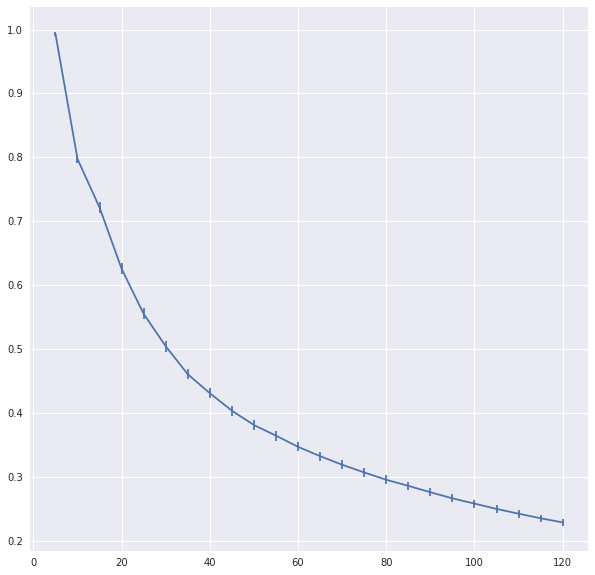

In [346]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(subset_size_list,np.mean(mean_ci_width_cfg_mean_norm,1),yerr=np.std(mean_ci_width_cfg_mean_norm,1)/np.sqrt(nrois));

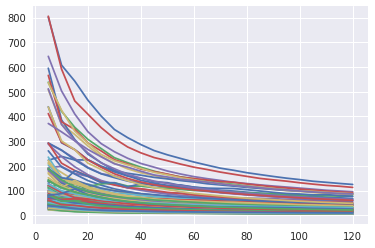

In [520]:
plt.plot(subset_size_list,mean_ci_width_cfg_mean);

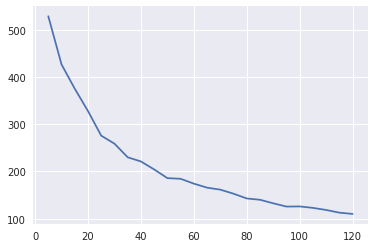

In [309]:
plt.plot(subset_size_list,mean_ci_width)

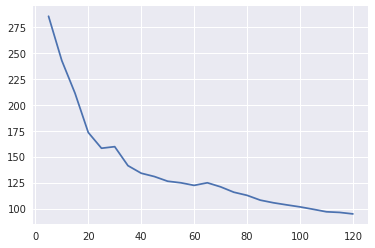

In [311]:
plt.plot(subset_size_list,std_ci_width)

Text(0,0.5,u'Normalized Slope')

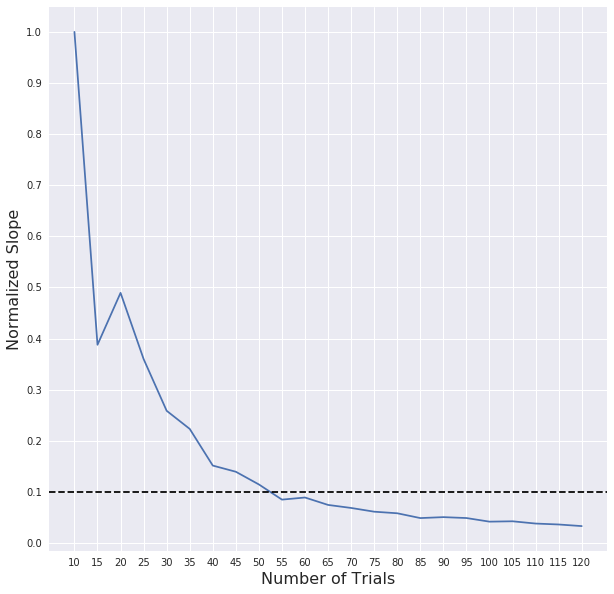

In [357]:
fig = plt.figure(figsize=(10,10))
plt.plot(subset_size_list[1:],np.diff(np.mean(mean_ci_width_cfg_mean_norm,1))/np.min(np.diff(np.mean(mean_ci_width_cfg_mean_norm,1))))
ax = plt.gca()
ax.set_xticks(np.arange(10,125,5))
ax.set_yticks(np.arange(0,1.1,.1))
plt.axhline(y=0.1,color = 'k', linestyle = '--')
plt.xlabel('Number of Trials',fontsize = 16)
plt.ylabel('Normalized Slope',fontsize = 16)

In [350]:
np.min(np.diff(np.mean(mean_ci_width_cfg_mean_norm,1)))

-0.1958787498416652

In [303]:
est_value.value

306.71234329651156

In [283]:
print(bs.bootstrap(response_matrix_df_cells[0:120,0,3], stat_func=bs_stats.std))

306.712343297    (262.161027005, 355.6538626)


In [481]:
#checking ROC curves

from sklearn import metrics

active_cells_manual = np.array([0,1,1,1,0,1,
 0,1,1,1,1,0,#11
 1,1,0,0,1,0,#17
 1,1,1,1,0,1,#23
 0,1,0,1,1,0,
 0,1,1,1,0,0,#35
 1,1,0,1,0,1,
 0,0,1,1,1,1,#47
 0,1,0,1,0,0,
 1,1,0,1,1,0,#59
 1,1,0,0,1,0,
 0,0,1,1,0,0,
 1,0,0,0,0,0,
 0,1,1,0,1,0,
 1,0,0,1,0,1,#89
 1,0,1,1,1,1,
 1,0,0,0,1,0,
 1,0,1,1,0,0,
 1,1,1,1,1,0,#113
 1,1,1,0,1,1,
 0,1,1,0,1,1,
 0,0,0,0,0,1,
 1,0,0,0,0,0,#137
 1,1,1,1,1,1,#143
 1,1])#hand-scored data for JC105, 20190826

print('Number of active cells, manual %i'%(np.sum(active_cells_manual)))

Number of active cells, manual 82


In [498]:
nreps = 100
subset_size_list = np.arange(5,int(np.floor(ntrials))+5,5)#np.array([4,8,12])

auc_score = np.zeros((subset_size_list.size,nreps))

for rep in range(nreps):
    print(rep)
    for subset_idx,subset_size in enumerate(subset_size_list):
        # rep = 0
        # subset_idx = 0
        # subset_size = 60

        #randomly subsample
        rand_trials = np.random.permutation(ntrials)
        subset_response = response_matrix_df_cells[rand_trials[0:subset_size],:,:]
        
        sub_tstat = np.empty((nconfigs,nrois))
        sub_p = np.empty((nconfigs,nrois))
        for cidx in range(nconfigs):
                for ridx in range(nrois):
                    sub_tstat[cidx,ridx], sub_p[cidx,ridx] = stats.ttest_1samp(np.squeeze(subset_response[:,cidx,ridx]),0)

        
        scores_sub = np.max(sub_tstat,0)
        #get roc metrix
        auc_score[subset_idx,rep] = metrics.roc_auc_score(active_cells_manual, scores_sub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [507]:
auc_score_mean = np.mean(auc_score,1)
auc_score_se = np.std(auc_score,1)/np.sqrt(nreps)

In [508]:
auc_score_se

array([  4.27846631e-03,   3.10397010e-03,   2.67756570e-03,
         1.97139116e-03,   1.88358868e-03,   1.60990030e-03,
         1.36619654e-03,   1.27764881e-03,   1.02950006e-03,
         1.06092174e-03,   7.88217094e-04,   8.63505937e-04,
         7.84112723e-04,   7.20161060e-04,   6.36608019e-04,
         6.89884774e-04,   5.82121846e-04,   4.75979411e-04,
         4.63280478e-04,   4.23934467e-04,   3.15092964e-04,
         2.55112298e-04,   2.04448364e-04,   3.33066907e-17])

Text(0,0.5,u'AUC Score')

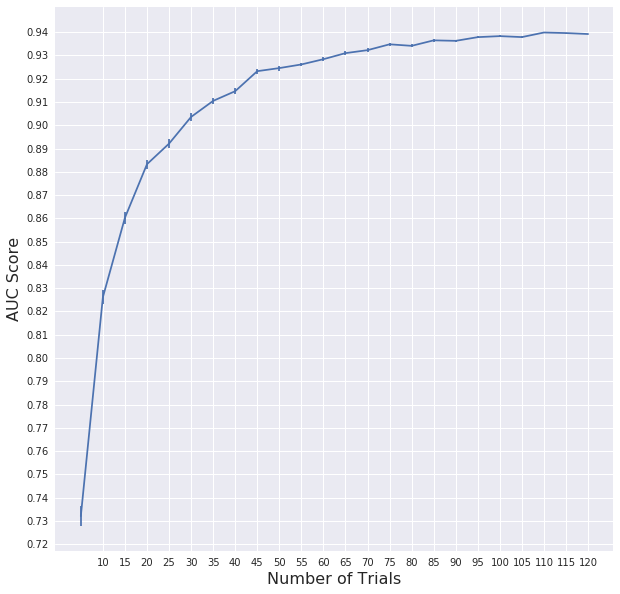

In [510]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(subset_size_list,auc_score_mean,yerr=auc_score_se)
ax = plt.gca()
ax.set_xticks(np.arange(10,125,5))
ax.set_yticks(np.arange(.72,.95,.01))
#plt.axhline(y=auc_score_mean[-1]-auc_score_se[-1],color = 'k', linestyle = '--')
plt.xlabel('Number of Trials',fontsize = 16)
plt.ylabel('AUC Score',fontsize = 16)

In [460]:


scores = np.max(simple_tstat,0)

#for scores, 

fpr, tpr, thresholds = metrics.roc_curve(active_cells_manual, scores, pos_label=1)

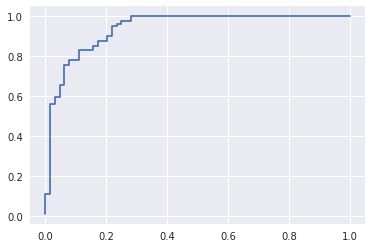

In [461]:
plt.plot(fpr,tpr)

0.934070121951


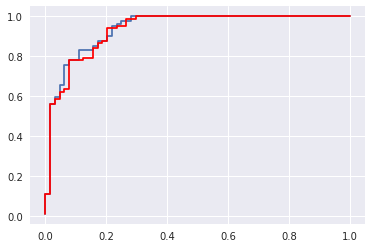

In [480]:
subset_size = 110
rand_trials = np.random.permutation(ntrials)
subset_response = response_matrix_df_cells[rand_trials[0:subset_size],:,:]





#for scores, 

fpr_sub, tpr_sub, thresholds = metrics.roc_curve(active_cells_manual, scores_sub, pos_label=1)
auc_score = metrics.roc_auc_score(active_cells_manual, scores_sub)

print(auc_score)
plt.plot(fpr,tpr)
plt.plot(fpr_sub,tpr_sub,'r')